# Support Vector Regression

Primero, importamos los paquetes necesarios y cargamos los datos en un dataframe

In [1]:
import pandas as pd
import numpy as np

#eval metrics
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae

#Scaler y SVR
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
# cargamos el dataset
dataset = pd.read_csv('dataset.csv', encoding='utf-8',skiprows=lambda x: (x != 0) and not x % 2)
# Guardamos los datos importantes en un dataframe
d = {'LV ActivePower (kW)': dataset['LV ActivePower (kW)'] , 'Wind Speed (m/s)': dataset['Wind Speed (m/s)'],'Wind Direction (°)': dataset['Wind Direction (°)']}
df = pd.DataFrame(data = d)

In [2]:
# Formatea las variables de tal forma que las pueda admitir el algoritmo
def fix_parameters(X, m, delta):
    left_stop = (m + delta)
    tam = X.size - left_stop
    i = X.size - 1
    X_fixed = []
    y_fixed = []
    while i >= left_stop:
        X_fixed = np.append(X_fixed, X[(i + 1 - left_stop):(i + 1) - delta])
        y_fixed = np.append(y_fixed, X[i])
        i = i - 1
    X_fixed = np.reshape(X_fixed, (tam, m))
  
    return X_fixed, y_fixed

Seleccionamos una columna con la que trabajar. Basta con descomentar una de las tres líneas de código a continuación

In [3]:
#X = df['LV ActivePower (kW)'].to_numpy()
X = df['Wind Direction (°)'].to_numpy()
#X = df['Wind Speed (m/s)'].to_numpy()

Dividimos los datos en entrenamiento y testeo

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.4, shuffle=False)

Escalamos los datos

In [5]:
scaler = StandardScaler() 
scaler.fit(X_train.reshape(-1,1))
X_train_scaled=scaler.transform(X_train.reshape(-1,1))
X_test_scaled=scaler.transform(X_test.reshape(-1,1))

A continuación, formateamos los datos de manera que puedan ser introducidos en el regresor. Para ello establecemos una m, que consiste en la cantidad de datos de entrenamiento que queramos utilizar, y una delta, que es el tiempo a futuro que queremos predecir. Tras eso, simplemente tenemos que llamar a la función definida previamente "fix_parameters" que devuelve una matriz y un array listos para ser usados.

In [6]:
#1 hora = 3
#6 horas = 18
#12 horas = 36
#1 día = 72
#3 días = 216
#1 semana = 504

m = 72
delta = 18

X_train_fixed, y_train_fixed = fix_parameters(X_train_scaled, m, delta)
X_test_fixed, y_test_fixed = fix_parameters(X_test_scaled, m, delta)

La siguiente función consiste en una búsqueda de los parámetros con los mejores resultados para nuestros datos actuales. Prueba diferentes valores para los 3 parámetros a tener en cuenta en nuestro modelo

In [7]:
#comprobación de los mejores parámetros
def best_params():
    epsilons = np.arange(0.1, 1.1, 0.2) 
    Cs = [1, 100, 1000]#, 1000000]
    gammas = ['scale', 'auto']
    best_gamma = -1
    best_c = -1
    best_epsilon = -1
    mejor_error = 10
    First = True
    for c in Cs: #comprobamos la mejor C
        for e in epsilons: #comprobamos la mejor epsilon
            for g in gammas: #comprobamos la mejor gamma
                regressor = SVR(kernel = 'rbf', C = c, epsilon = e, gamma = g, verbose = False)
                regressor.fit(X_train_fixed, y_train_fixed)
                pred = regressor.predict(X_test_fixed)
                error = mean_squared_error(scaler.inverse_transform(y_test_fixed.reshape(-1,1)), scaler.inverse_transform(pred.reshape(-1,1)), squared= False)
                print("C, EPSILON, GAMMA: ")
                print(c)
                print(e)
                print(g)
                print(error)
                if error < mejor_error or First:
                    if First == True: First = False
                    mejor_error = error
                    best_gamma = g
                    best_c = c
                    best_epsilon = e
                    
    return best_c,best_epsilon,best_gamma

Utilizando la función definida previamente "best_params", buscamos los mejores parámetros para este caso

In [8]:
c,e,g = best_params()

C, EPSILON, GAMMA: 
1
0.1
scale
66.13010779669416
C, EPSILON, GAMMA: 
1
0.1
auto
66.1303349930071
C, EPSILON, GAMMA: 
1
0.30000000000000004
scale
66.28343408171152
C, EPSILON, GAMMA: 
1
0.30000000000000004
auto
66.28395109197092
C, EPSILON, GAMMA: 
1
0.5000000000000001
scale
67.65878849419052
C, EPSILON, GAMMA: 
1
0.5000000000000001
auto
67.65746774473703
C, EPSILON, GAMMA: 
1
0.7000000000000001
scale
71.20651632796705
C, EPSILON, GAMMA: 
1
0.7000000000000001
auto
71.21001858359605
C, EPSILON, GAMMA: 
1
0.9000000000000001
scale
77.38854636773728
C, EPSILON, GAMMA: 
1
0.9000000000000001
auto
77.39355432541109
C, EPSILON, GAMMA: 
100
0.1
scale
78.65958762924313
C, EPSILON, GAMMA: 
100
0.1
auto
78.6601825538482
C, EPSILON, GAMMA: 
100
0.30000000000000004
scale
78.70913414845339
C, EPSILON, GAMMA: 
100
0.30000000000000004
auto
78.7092738969381
C, EPSILON, GAMMA: 
100
0.5000000000000001
scale
78.82603133165352
C, EPSILON, GAMMA: 
100
0.5000000000000001
auto
78.82635719175634
C, EPSILON, GAM

In [9]:
print(c)
print(e)
print(g)

1
0.1
scale


Entrenamos el algoritmo y predecimos los datos de testeo

In [10]:
regressor = SVR(kernel = 'rbf', C = c, epsilon = e, gamma = g, verbose = False)
regressor.fit(X_train_fixed, y_train_fixed)
pred = regressor.predict(X_test_fixed)

Aquí podemos observar las predicciones en una gráfica, en comparación con los datos reales

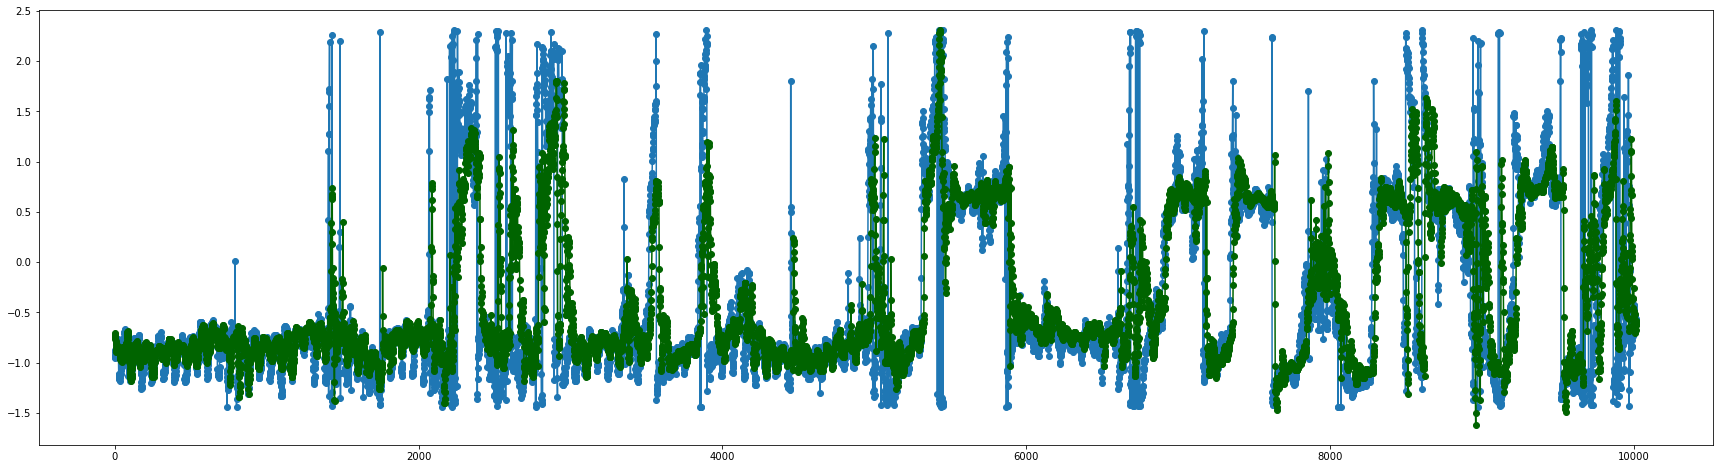

In [11]:
import numpy as np
from matplotlib import pyplot as plt 


fig,ax = plt.subplots(figsize=(30,8))

plot_start = 25000
# plot the training data 
#ax.plot(range(y_train_fixed.size),X_train[504+18:],'navy',marker='o',label='observed')
#ax.plot(X_training[m:],pred_train,'pink',marker='o',label='pred_train')
# plot the test data
ax.plot(range(y_test_fixed.size),np.flip(y_test_fixed),marker='o')
ax.plot(range(pred.size),np.flip(pred.reshape(-1,1)),'darkgreen',marker='o',label='pred')

Con esto, podemos observar la evolución del error en una gráfica:

In [12]:
list_error = np.empty(len(pred))

#invertimos el escalado para comprobar cuánto se alejan realmente las predicciones de los datos reales
pred_error = scaler.inverse_transform(pred.reshape(-1,1))
y_error = scaler.inverse_transform(y_test_fixed.reshape(-1,1))

for i in range (len(pred)):
  list_error[i] = abs(pred_error[i]-y_error[i])

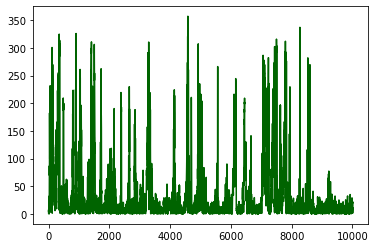

In [13]:
plt.plot(range(pred.size),list_error, 'darkgreen')

Comprobamos la efectividad del algoritmo con RMSE, MAE y R2

In [14]:
#R2
r2(y_test_fixed, pred)

0.3935409384612214

In [15]:
#RMSE
mean_squared_error(scaler.inverse_transform(y_test_fixed.reshape(-1,1)), scaler.inverse_transform(pred.reshape(-1,1)), squared= False)

66.13010779669416

In [16]:
#MAE
mae(scaler.inverse_transform(y_test_fixed.reshape(-1,1)), scaler.inverse_transform(pred.reshape(-1,1)))

36.12076050351093